In [532]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import rand

# Implementing the screening rule

In [533]:
def compute_prox(x, mu):
    p = np.zeros(x.size)
    for i in range(x.size):
        if np.abs(x[i]) > mu:
            p[i] = (1 - mu / np.abs(x[i])) * x[i]
    return p

def compute_prox_subgradient(u, mu):
    g = np.zeros(u.size)
    for i in range(u.size):
        if np.abs(u[i]) > mu:
            g[i] = 1
        elif np.abs(u[i]) < mu:
            g[i] = 0
        else:
            g[i] = np.random.rand(1)[0]
    return g

def compute_l1_subgradient(u):
    g = np.zeros(u.size)
    for i in range(u.size):
        if u[i] != 0:
            g[i] = np.sign(u[i])
        else:
            g[i] = 2 * np.random.rand(1)[0] - 1
    return g

def compute_subgradient(x, D, y, lmbda, mu):
    output = D.dot(x) - y
    g_1 = compute_prox_subgradient(output, mu)
    g_1 = np.transpose(D).dot(np.diag(g_1))
    g_1 = g_1.dot(compute_prox(output, mu))
    g_2 = compute_l1_subgradient(x)
    g = g_1 + lmbda * g_2
    return g

def update_ellipsoid(z, A, g):
    p = z.size
    A_g = A.dot(g)
    den = np.sqrt(g.dot(A_g))
    g = (1 / den) * g
    A_g = A.dot(g)
    z = z - (1 / (p + 1)) * A_g
    A = (p ** 2 / (p ** 2 - 1)) * (A - (2 / (p + 1)) * np.outer(A_g, A_g))
    return z, A

def iterate_ellipsoids(D, y, z_init, A_init, lmbda, mu, n_steps=100):
    k = 0
    z = z_init
    A = A_init
    while k < n_steps:
        g = compute_subgradient(z, D, y, lmbda, mu)
        z, A = update_ellipsoid(z, A, g)
        k += 1 
    return z, A

def compute_test(D_i, y_i, z, A):
    test = D_i.dot(z) + np.sqrt( (D_i.dot(A.dot(D_i)))/ 2) - y_i
    return test

def compute_test_with_linear_ineq(D_i, y_i, z, A, g):
    nu = g.dot(A.dot(D_i)) / g.dot(A.dot(g))
    if nu < 0:
        test = compute_test(D_i, y_i, z, A)
    else:
        new_D_i = D_i - nu * g
        mu = np.sqrt(new_D_i.dot(A.dot(new_D_i))) / 2
        body = D_i.dot(A.dot(new_D_i)) / (2 * mu)
        test = D_i.dot(z) + body - y_i
    return test

def test_dataset(D, y, z, A, lmbda, mu, linear_ineq=True):
    results = np.zeros(D.shape[0])
    g = compute_subgradient(z, D, y, lmbda, mu)
    for i in range(D.shape[0]):
        if linear_ineq:
            test_1 = compute_test_with_linear_ineq(D[i], y[i], z, A, g)
            test_2 = compute_test_with_linear_ineq(-D[i], -y[i], z, A, g)
        else:
            test_1 = compute_test(D[i], y[i], z, A)
            test_2 = compute_test(-D[i], -y[i], z, A)
        if test_1 < mu and test_2 < mu:
            results[i] = 1
    return results

# Generating the data

In [534]:
#import data, real and synthetic

def make_data(param_set, noise=True):

    n = param_set[0]
    p = param_set[1]
    sparsity = param_set[2]
    X = np.zeros((n,p))
    y = np.zeros(n)
    true_params = rand(p, 1, density = sparsity).A.ravel()
    print(np.linalg.norm(true_params, ord=1))
    sparse_ones = np.zeros(p)
    for i in range(p):
        if true_params[i] != 0:
            sparse_ones[i] = 1
    true_params = 2 * true_params - sparse_ones

    noise_norm = 0

    for i in range(n):
        # sample x in [-1,1]^p box
        x = 2 * np.random.rand(p) - np.ones(p) 
        X[i,:] = x
        y[i] = np.dot(true_params,x)
        if noise:
            w = np.random.randn(1) / 10
            y[i] += w
            noise_norm = np.linalg.norm(w)

    return X, y, true_params, noise_norm

param_set = (100, 10, 0.2)
X, y, true_params, _ = make_data(param_set)

1.39176257637


# Testing the screening rule

## Synthetic dataset

In [553]:
%matplotlib notebook

from mpl_toolkits.mplot3d import Axes3D 

# we generate the dataset, find the set X for x and execute the test.
param_set = (100, 2, 1/2)
X, y, true_params, _ = make_data(param_set)
z_init = np.zeros(2)
A_init = 2 * np.identity(2) #TODO: find rule for the radius

0.598866704845


In [584]:
lmbda = 100 #TODO: find rule for lmbda
mu = 0.1 #TODO: evaluate sensitivity in mu
z, A = iterate_ellipsoids(X, y, z_init, A_init, lmbda, mu)

[ 0.  0.  1.  0.  1.  1.  1.  0.  1.  0.  1.  1.  1.  0.  1.  1.  1.  0.
  1.  1.  1.  0.  1.  1.  0.  0.  0.  1.  1.  0.  0.  1.  0.  1.  1.  1.
  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.  0.
  0.  1.  1.  0.  1.  0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  1.  1.  0.
  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  1.  1.  1.  1.  1.  1.
  0.  1.  1.  0.  0.  1.  1.  1.  0.  0.] 49


<IPython.core.display.Javascript object>


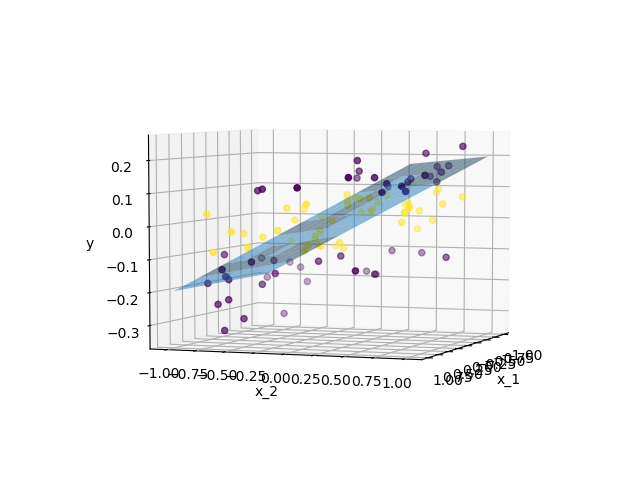

In [588]:
results = test_dataset(X, y, z, A, lmbda, mu, linear_ineq=True)
print(results, np.count_nonzero(results))

visible = True

if visible:
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X[:,0], X[:,1], y, c=results)

    # we plot the plane from which the datapoints are generated
    x_1_true = np.linspace(-1,1,10)
    x_2_true = np.linspace(-1,1,10)
    X_1_true, X_2_true = np.meshgrid(x_1_true, x_2_true)
    y_real = true_params[0] * X_1_true + true_params[1] * X_2_true
    ax.plot_surface(X_1_true, X_2_true, y_real, alpha=0.5)
    ax.set_xlabel('x_1')
    ax.set_ylabel('x_2')
    ax.set_zlabel('y')
    plt.show()

The more we regularize, the lower the coefficient must be : the real model cannot be recovered and the screened points describe the plane that would be recovered using a Lasso with such lambda (to be verified). This probably explains why less datapoints are screened : since the solution that will be recovered by the Lasso with such lambda is less close to the ground truth, more points are going to pass the test (i.e prediction far from the ground truth) and not be discarded!

## Real dataset

### n > p

In [590]:
# Idée : appliquer la règle au dataset et voir combien de points sont écartés, quelle est la 
#sensibilité en mu, au nombre de steps de l'ellipse et à l'initialisation.

from sklearn.datasets import load_boston

boston = load_boston()
print(boston.data.shape, boston.target.shape)

z_init = np.zeros(13)
A_init = np.sqrt(13) * np.identity(13) # hyp : La solution est dans une boule de rayon sqrt(p)
lmbda = 0.1 
mu = 1000
z, A = iterate_ellipsoids(boston.data, boston.target, z_init, A_init, lmbda, mu)
results = test_dataset(boston.data, boston.target, z, A, lmbda, mu, linear_ineq=True)
print(results, np.count_nonzero(results))

(506, 13) (506,)
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  

Il y a un problème car rajouter une contrainte d'inégalité fait que l'on screene moins de datapoints. En effet, si le problème est plus contraint, alors son maximum pour un datapoint donné est plus petit, et ce datapoint a donc plus de chances de se faire écarter.

### n < p

In [508]:
import pandas as pd 

l_data = pd.read_csv('/nas/home2/g/gmialon/research/datasets/leukemia_big.csv')

def create_X_y(data):
    
    X = np.transpose(data.values)
    y_ = data.columns.values
    y = np.ones(len(y_))
    for i in range(len(y_)):
        if 'AML' in y_[i]:
            y[i] = -1
    return X, y

X, y = create_X_y(l_data)

z_init = np.zeros(X.shape[1])
A_init = np.sqrt(X.shape[1]) * np.identity(X.shape[1]) # hyp : La solution est dans une boule de rayon sqrt(p)

lmbda_grid = [1] # lambda does not change too much what happens (some are screened, some others not anymore)
mu_grid = [1, 10, 100, 1000, 10000] # a good value to screen is 5036 with radius = dim

for lmbda in lmbda_grid:
    for mu in mu_grid:
        z, A = iterate_ellipsoids(X, y, z_init, A_init, lmbda, mu)
        results = test_dataset(X, y, z, A, mu)
        print(lmbda, mu, results)

KeyboardInterrupt: 

Question:
- Sensibilité à l'initialisation, au nombre de steps d'ellipsoides, à mu.
- Quand tout cela varie, les points éliminés le sont-ils de façon consistante?
- Peut-on fitter des modèles sur les points non-screenés et maintenir un bon niveau de performance? (par-rapport à une élimination random)

Y-a-t-il un scaling à faire pour Dx - y ?
Intercept ? Recouper l'ellipse avec un plan
Essayer d'initialiser à un point proche de la solution
